In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (12, 6)
%config InlineBackend.figure_format = 'retina'

fname = '/data9/GR6901/data/CERES_EBAF-TOA_Edition4.0_200003-201701.condensed.nc'
print(fname)

/data9/GR6901/data/CERES_EBAF-TOA_Edition4.0_200003-201701.condensed.nc


## 1.1) Open the dataset and display its contents

In [2]:
df=xr.open_dataset(fname)
df

ERROR 1: PROJ: proj_create_from_database: Open of /opt/sw/anaconda3/2023.09/envs/pangeo23/share/proj failed


<xarray.Dataset>
Dimensions:                      (lon: 360, time: 203, lat: 180)
Coordinates:
  * lon                          (lon) float32 0.5 1.5 2.5 ... 357.5 358.5 359.5
  * time                         (time) datetime64[ns] 2000-03-15 ... 2017-01-15
  * lat                          (lat) float32 -89.5 -88.5 -87.5 ... 88.5 89.5
Data variables: (12/14)
    toa_sw_all_mon               (time, lat, lon) float32 ...
    toa_lw_all_mon               (time, lat, lon) float32 ...
    toa_net_all_mon              (time, lat, lon) float32 ...
    toa_sw_clr_mon               (time, lat, lon) float32 ...
    toa_lw_clr_mon               (time, lat, lon) float32 ...
    toa_net_clr_mon              (time, lat, lon) float32 ...
    ...                           ...
    toa_cre_net_mon              (time, lat, lon) float32 ...
    solar_mon                    (time, lat, lon) float32 ...
    cldarea_total_daynight_mon   (time, lat, lon) float32 ...
    cldpress_total_daynight_mon  (time, lat, lon) float32 ...
    cldtemp_total_daynight_mon   (time, lat, lon) float32 ...
    cldtau_total_day_mon         (time, lat, lon) float32 ...
Attributes:
    title:             CERES EBAF (Energy Balanced and Filled) TOA Fluxes. Mo...
    institution:       NASA/LaRC (Langley Research Center) Hampton, Va
    Conventions:       CF-1.4
    comment:           Data is from East to West and South to North.
    Version:           Edition 4.0; Release Date March 7, 2017
    Fill_Value:        Fill Value is -999.0
    DOI:               10.5067/TERRA+AQUA/CERES/EBAF-TOA_L3B.004.0
    Production_Files:  List of files used in creating the present Master netC...

## 1.2) Print out the long_name attribute of each variable
### Print variable: long name for each variable. Format the output so that the start of the long name attributes are aligned.

In [14]:
df.data_vars

for vname in df.data_vars:
    print(vname.ljust(30)+': '+df[vname].attrs['long_name'])

toa_sw_all_mon                : Top of The Atmosphere Shortwave Flux, Monthly Means, All-Sky conditions
toa_lw_all_mon                : Top of The Atmosphere Longwave Flux, Monthly Means, All-Sky conditions
toa_net_all_mon               : Top of The Atmosphere Net Flux, Monthly Means, All-Sky conditions
toa_sw_clr_mon                : Top of The Atmosphere Shortwave Flux, Monthly Means, Clear-Sky conditions
toa_lw_clr_mon                : Top of The Atmosphere Longwave Flux, Monthly Means, Clear-Sky conditions
toa_net_clr_mon               : Top of The Atmosphere Net Flux, Monthly Means, Clear-Sky conditions
toa_cre_sw_mon                : Top of The Atmosphere Cloud Radiative Effects Shortwave Flux, Monthly Means
toa_cre_lw_mon                : Top of The Atmosphere Cloud Radiative Effects Longwave Flux, Monthly Means
toa_cre_net_mon               : Top of The Atmosphere Cloud Radiative Effects Net Flux, Monthly Means
solar_mon                     : Incoming Solar Flux, Monthly Means


# 2) Basic reductions, arithmetic, and plotting

### 2.1) Calculate the time-mean of the entire dataset

In [221]:
timemean=df.mean(dim='time')



### 2.2) From this, make a 2D plot of the the time-mean Top of Atmosphere (TOA) Longwave, Shortwave, and Incoming Solar Radiation

(Use “All-Sky” conditions)

Note the sign conventions on each variable.

Text(0, 0.5, 'Latitude')

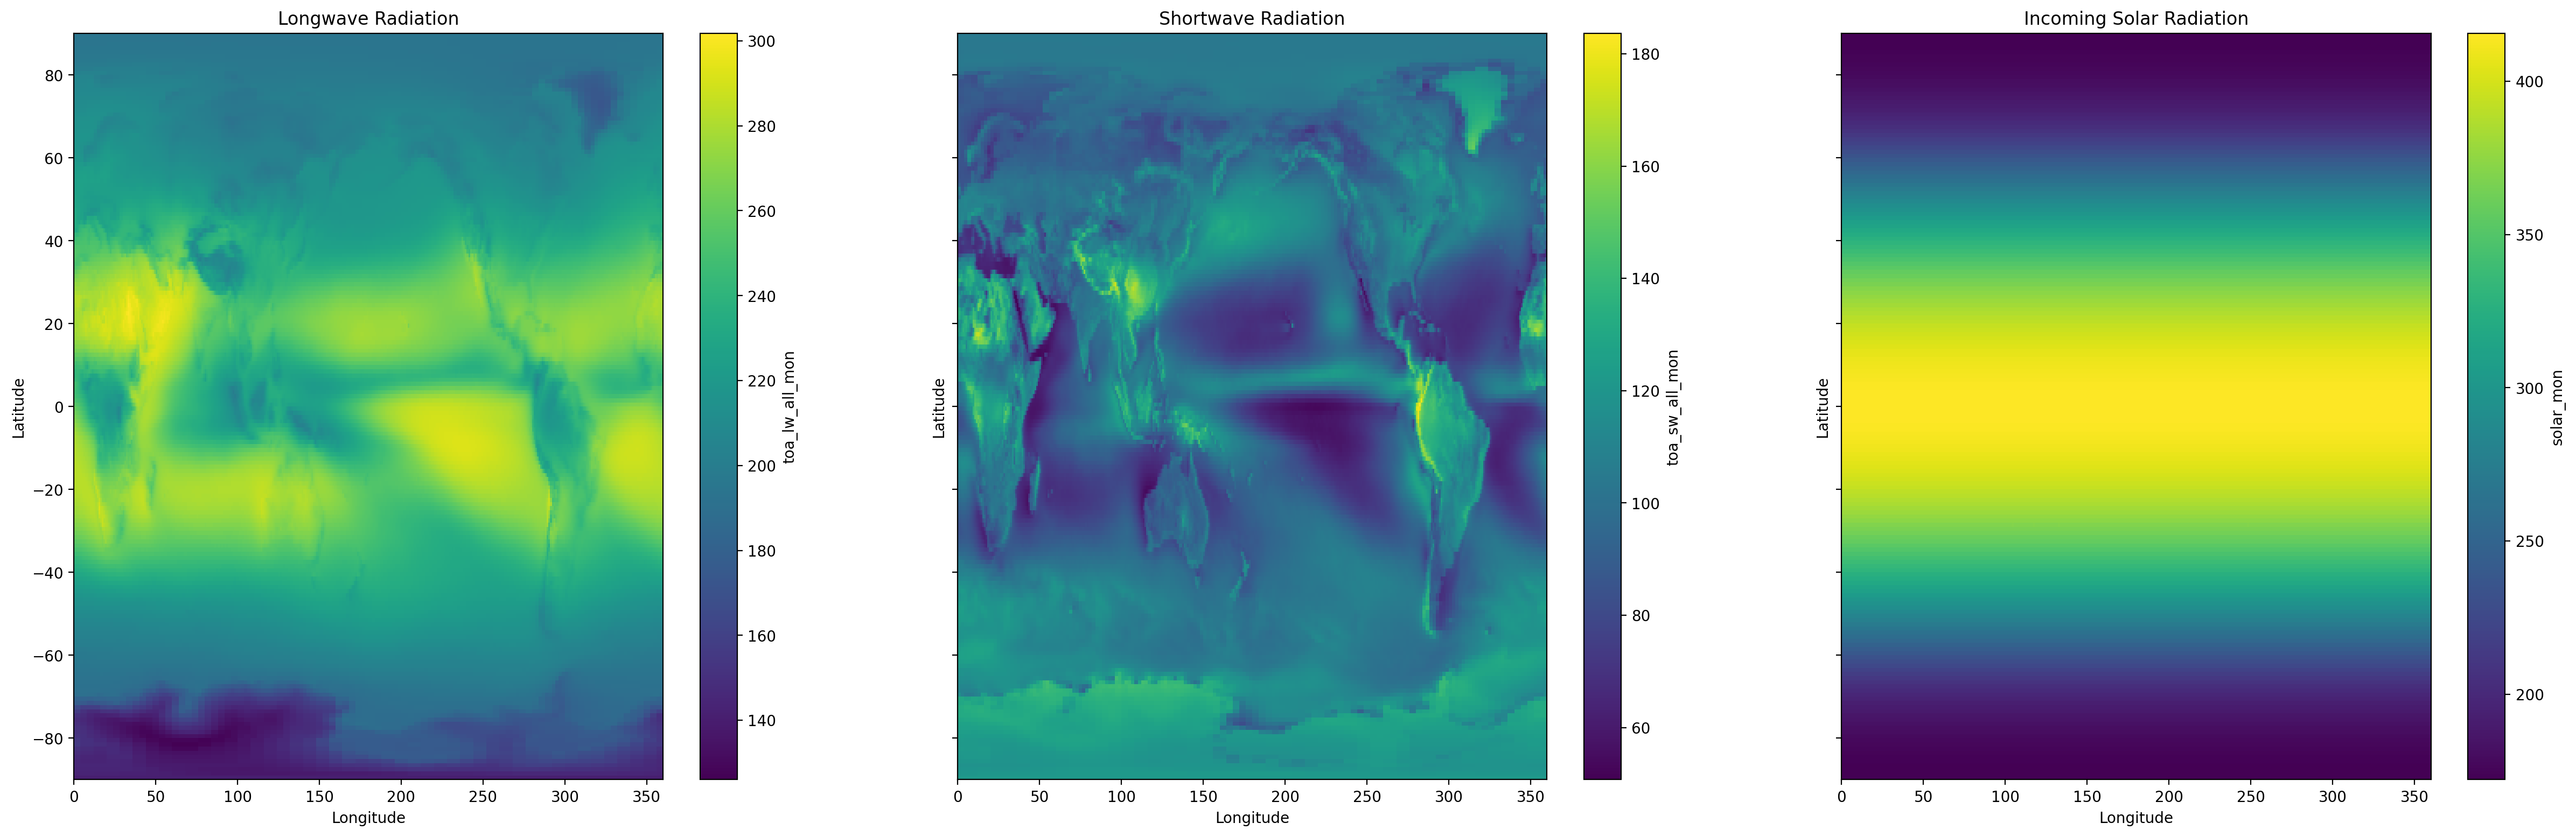

In [222]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(30,9),sharey=True)

timemean.toa_lw_all_mon.plot(ax=ax1)
ax1.set_title('Longwave Radiation')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
timemean.toa_sw_all_mon.plot(ax=ax2)
ax2.set_title('Shortwave Radiation')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
timemean.solar_mon.plot(ax=ax3)
ax3.set_title('Incoming Solar Radiation')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')

## 2.3) Add up the three variables above and verify (visually) that they are equivalent to the TOA net flux
You have to pay attention to and think carefully about the sign conventions (positive or negative) for each variable in order for the variables to sum to the right TOA net flux. Refer to the NASA figure at the top of the page to understand incoming and outgoing radiation.

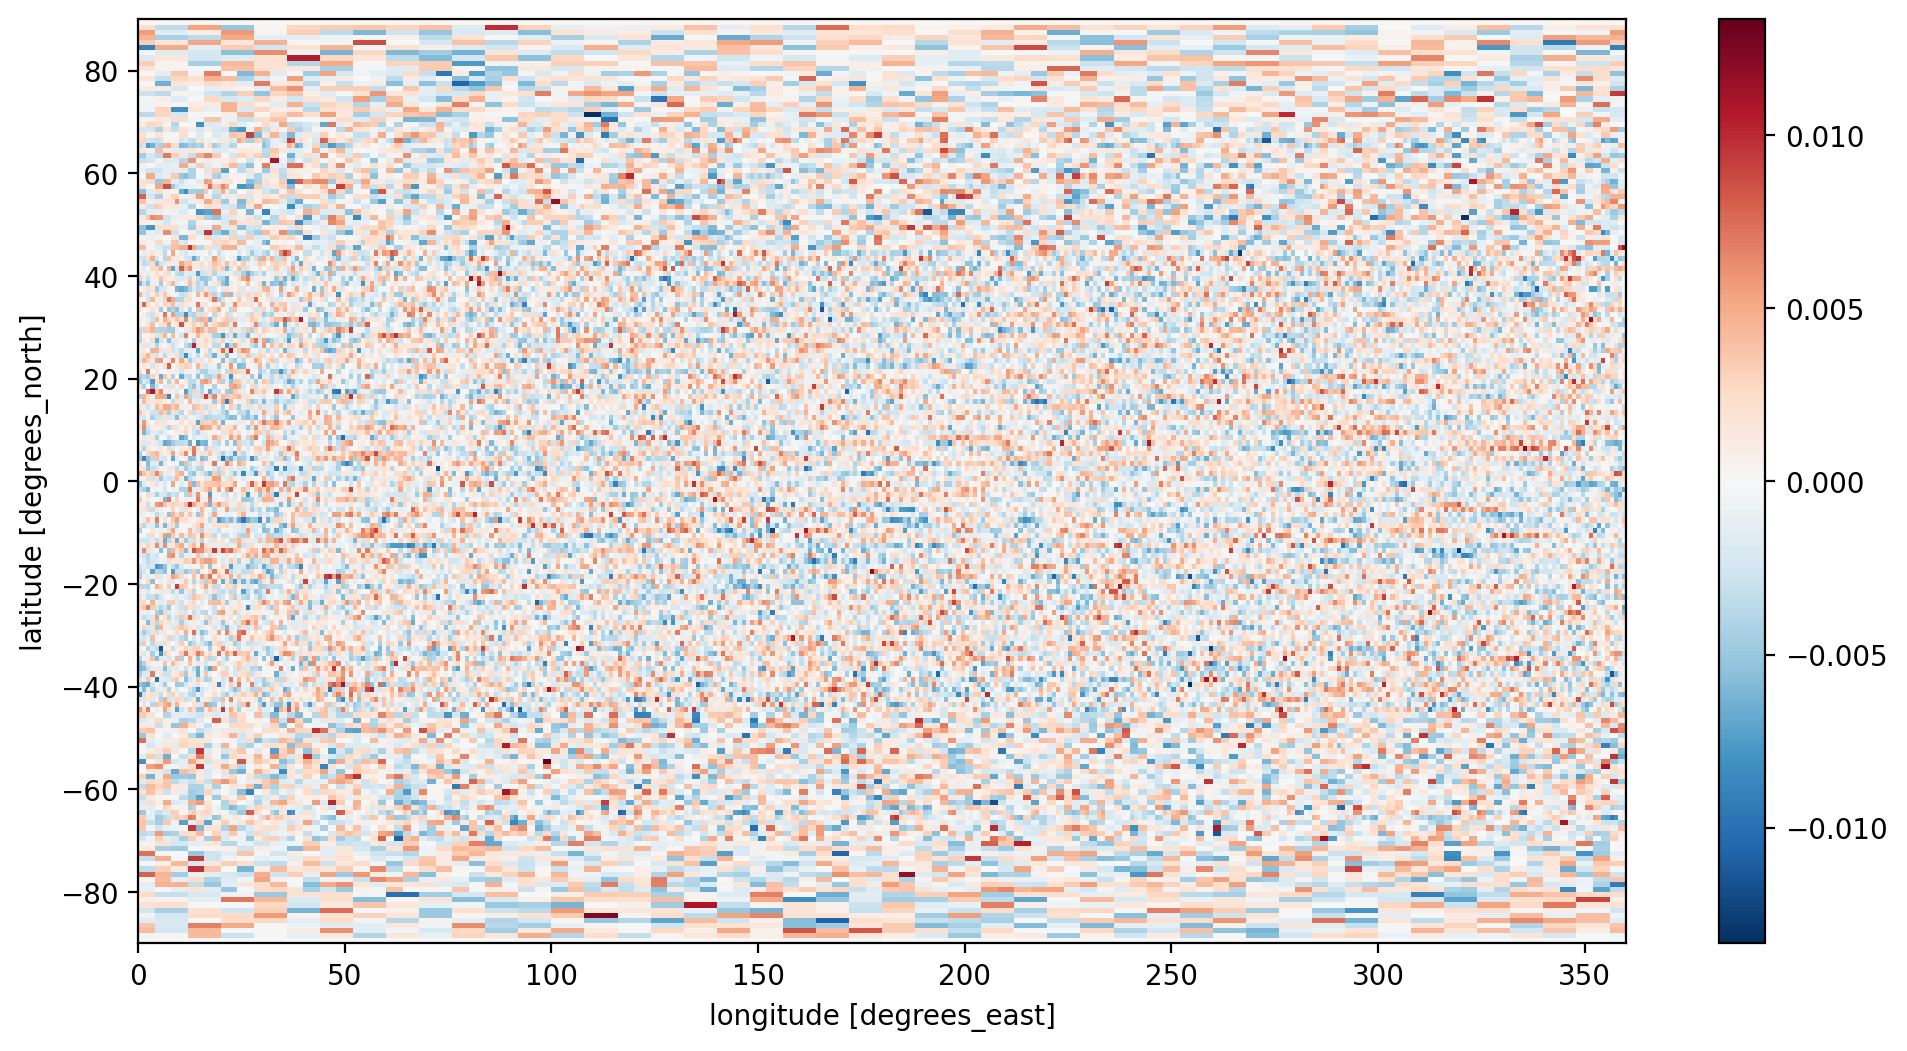

In [223]:
netflux=timemean.solar_mon-(timemean.toa_lw_all_mon+timemean.toa_sw_all_mon)

difference=netflux-timemean.toa_net_all_mon

difference.plot()



## 3) Mean and weighted mean
### 
3.1) Calculate the global (unweighted) mean of TOA net radiatio. 
Since the Earth is approximately in radiative balance, the net TOA radiation should be zero. But taking the naive mean from this dataset, you should find a number far from zero. Why?

The answer is that each “pixel” or “grid point” of this dataset does not represent an equal area of Earth’s surface. So naively taking the mean, i.e. giving equal weight to each point, gives the wrong ans

On a lat lon grid, the relative area of each grid point is proportional to cos($\lambda$). $\lambda$ is the latitudeatitude)

In [224]:
print(timemean.toa_net_all_mon.mean(dim=['lat','lon']))

<xarray.DataArray 'toa_net_all_mon' ()>
array(-28.729012, dtype=float32)


### 3.2) Create a weight array proportional to cos($\lambda$)

Think carefully a about radians vs. degrees

In [225]:
timemean=timemean.assign(earth_angle=lambda timemean: (0*timemean.lon)+np.cos(np.deg2rad(timemean.lat)))
timemean

<xarray.Dataset>
Dimensions:                      (lon: 360, lat: 180)
Coordinates:
  * lon                          (lon) float32 0.5 1.5 2.5 ... 357.5 358.5 359.5
  * lat                          (lat) float32 -89.5 -88.5 -87.5 ... 88.5 89.5
Data variables: (12/15)
    toa_sw_all_mon               (lat, lon) float32 122.3 122.3 ... 104.4 104.4
    toa_lw_all_mon               (lat, lon) float32 141.1 141.1 ... 194.1 194.1
    toa_net_all_mon              (lat, lon) float32 -91.29 -91.29 ... -126.3
    toa_sw_clr_mon               (lat, lon) float32 119.9 119.9 ... 89.47 89.47
    toa_lw_clr_mon               (lat, lon) float32 140.2 140.2 ... 200.4 200.4
    toa_net_clr_mon              (lat, lon) float32 -88.03 -88.03 ... -117.6
    ...                           ...
    solar_mon                    (lat, lon) float32 172.1 172.1 ... 172.3 172.3
    cldarea_total_daynight_mon   (lat, lon) float32 51.52 51.52 ... 78.93 78.93
    cldpress_total_daynight_mon  (lat, lon) float32 486.5 486.5 ... 766.9 766.9
    cldtemp_total_daynight_mon   (lat, lon) float32 225.2 225.2 ... 247.9 247.9
    cldtau_total_day_mon         (lat, lon) float32 4.158 4.158 ... 4.821 4.821
    earth_angle                  (lon, lat) float32 0.008727 ... 0.008727

### 3.3) Redo your global mean TOA net radiation calculation with this weight factor

Use xarray’s weighted array reductions to compute the weighted mean.

This time around, you should have found something much closer to zero. Ask a climate scientist what the net energy imbalance of Earth due to global warming is estimated to be. Do you think our calculation is precise enough to detect this?

In [226]:
netrad=timemean.toa_net_all_mon
weights=timemean.earth_angle

weighted_netrad=netrad.weighted(weights)
print(weighted_netrad.mean())

<xarray.DataArray 'toa_net_all_mon' ()>
array(0.8780836, dtype=float32)


### 3.4) Now that you have a weight factor, verify that the TOA incoming solar, outgoing longwave, and outgoing shortwave approximately match up with infographic shown in the first cell of this assignment

In [227]:
weighted_lw=timemean.toa_lw_all_mon.weighted(weights).mean()
weighted_sw=timemean.toa_sw_all_mon.weighted(weights).mean()
weighted_incom=timemean.solar_mon.weighted(weights).mean()

print(weighted_lw)
print(weighted_sw)
print(weighted_incom)


<xarray.DataArray 'toa_lw_all_mon' ()>
array(240.2667, dtype=float32)
<xarray.DataArray 'toa_sw_all_mon' ()>
array(99.13859, dtype=float32)
<xarray.DataArray 'solar_mon' ()>
array(340.28354, dtype=float32)


# 4) Meridional Heat Transport Calculation

### 4.1) calculate the pixel area using this formula and create a 2D (lon, lat) DataArray for it

In [228]:
area=xr.ones_like(timemean['toa_lw_all_mon'])
timemean=xr.merge([timemean,area.rename('area')])
timemean

timemean['area']=timemean.area*(6371000**2)*timemean.earth_angle*np.deg2rad(1)*np.deg2rad(1)

In [231]:
timemean.area.sum()

print('Surface Area of Sphere: '+str(4*np.pi*(6371000**2)))

Surface Area of Sphere: 510064471909788.25


### 4.2) Calculate and plot the total amount of net radiation in each 1-degree latitude band

Text(0, 0.5, 'Radiation in W')

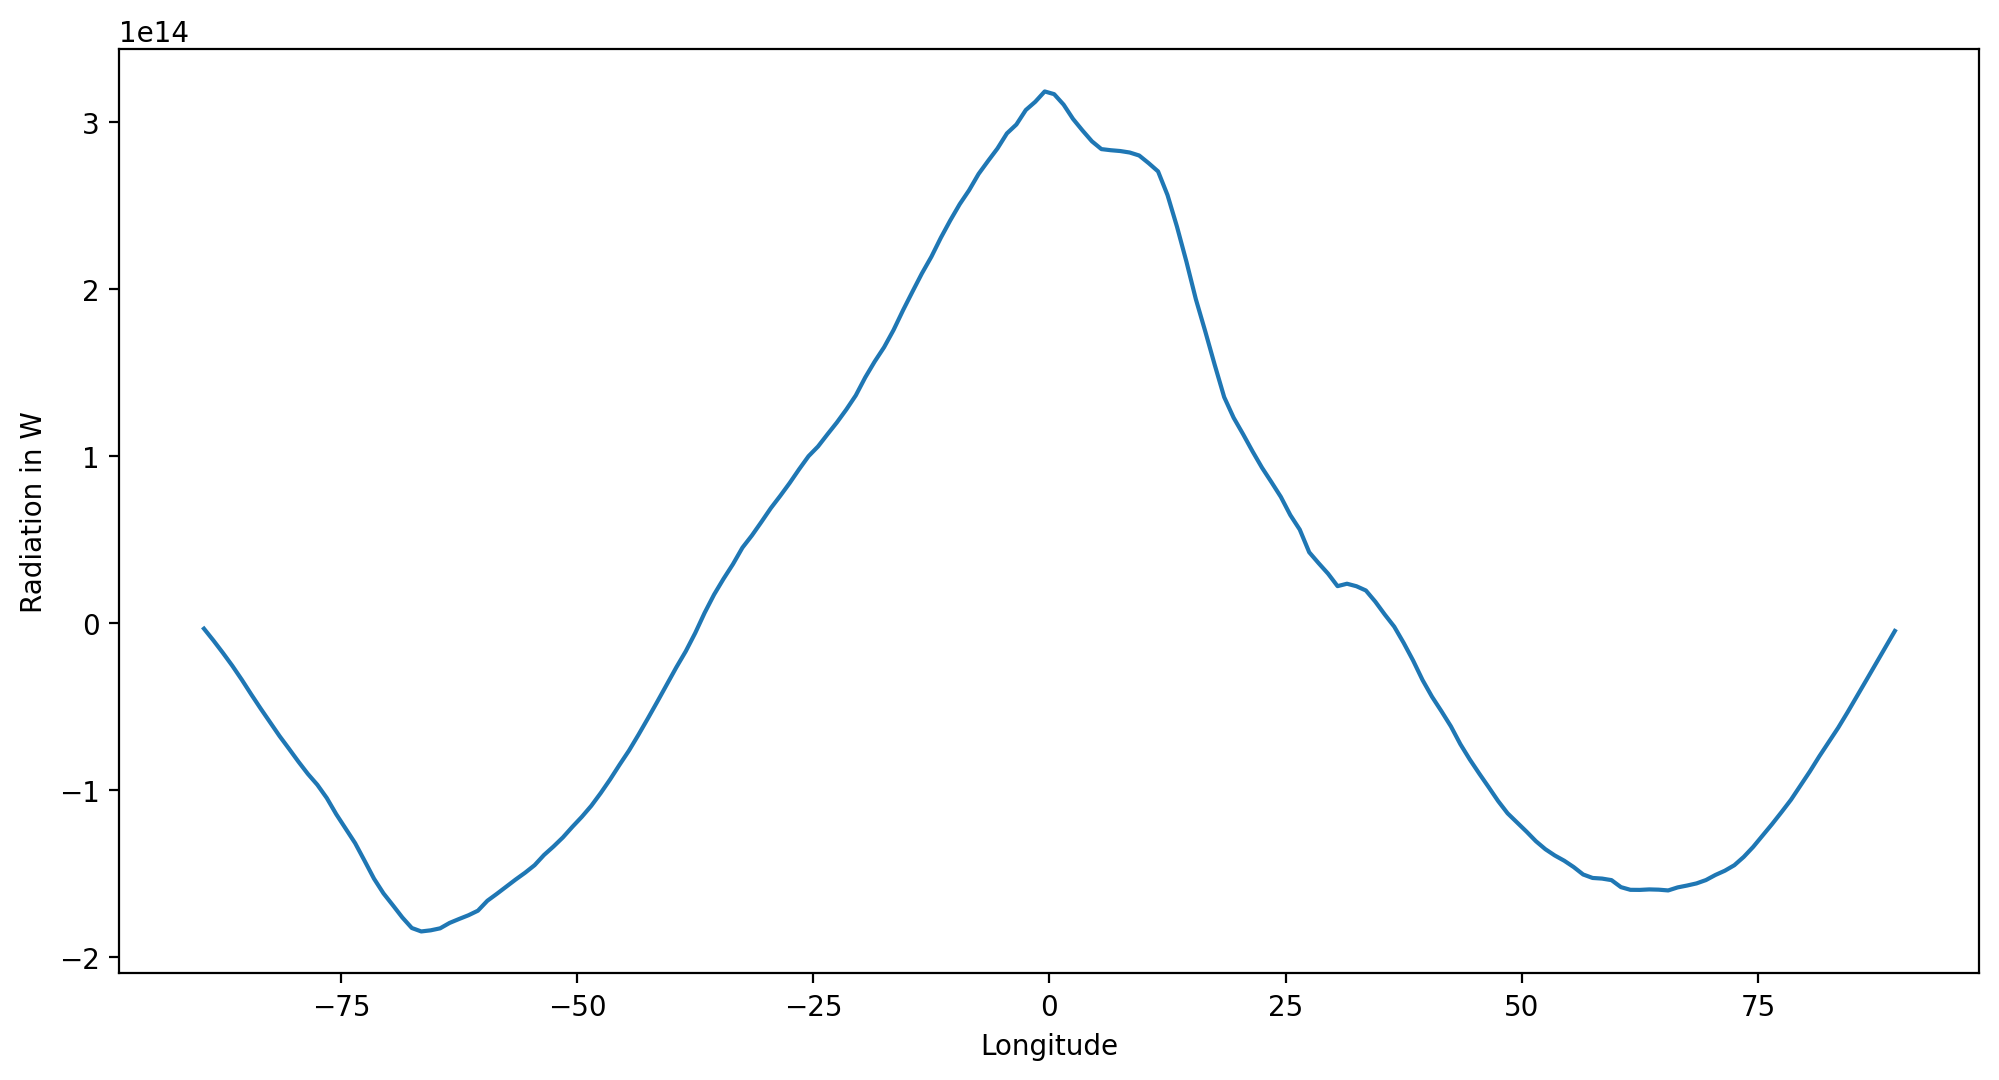

In [256]:
totalrad=timemean.toa_net_all_mon*timemean.area

totalrad.sum(dim='lon').plot()
plt.xlabel('Latitude')
plt.ylabel('Radiation in W')




## 4.3) Plot the cumulative sum of the total amount of net radiation as a function of latitude

Text(0, 0.5, 'Radiation in W')

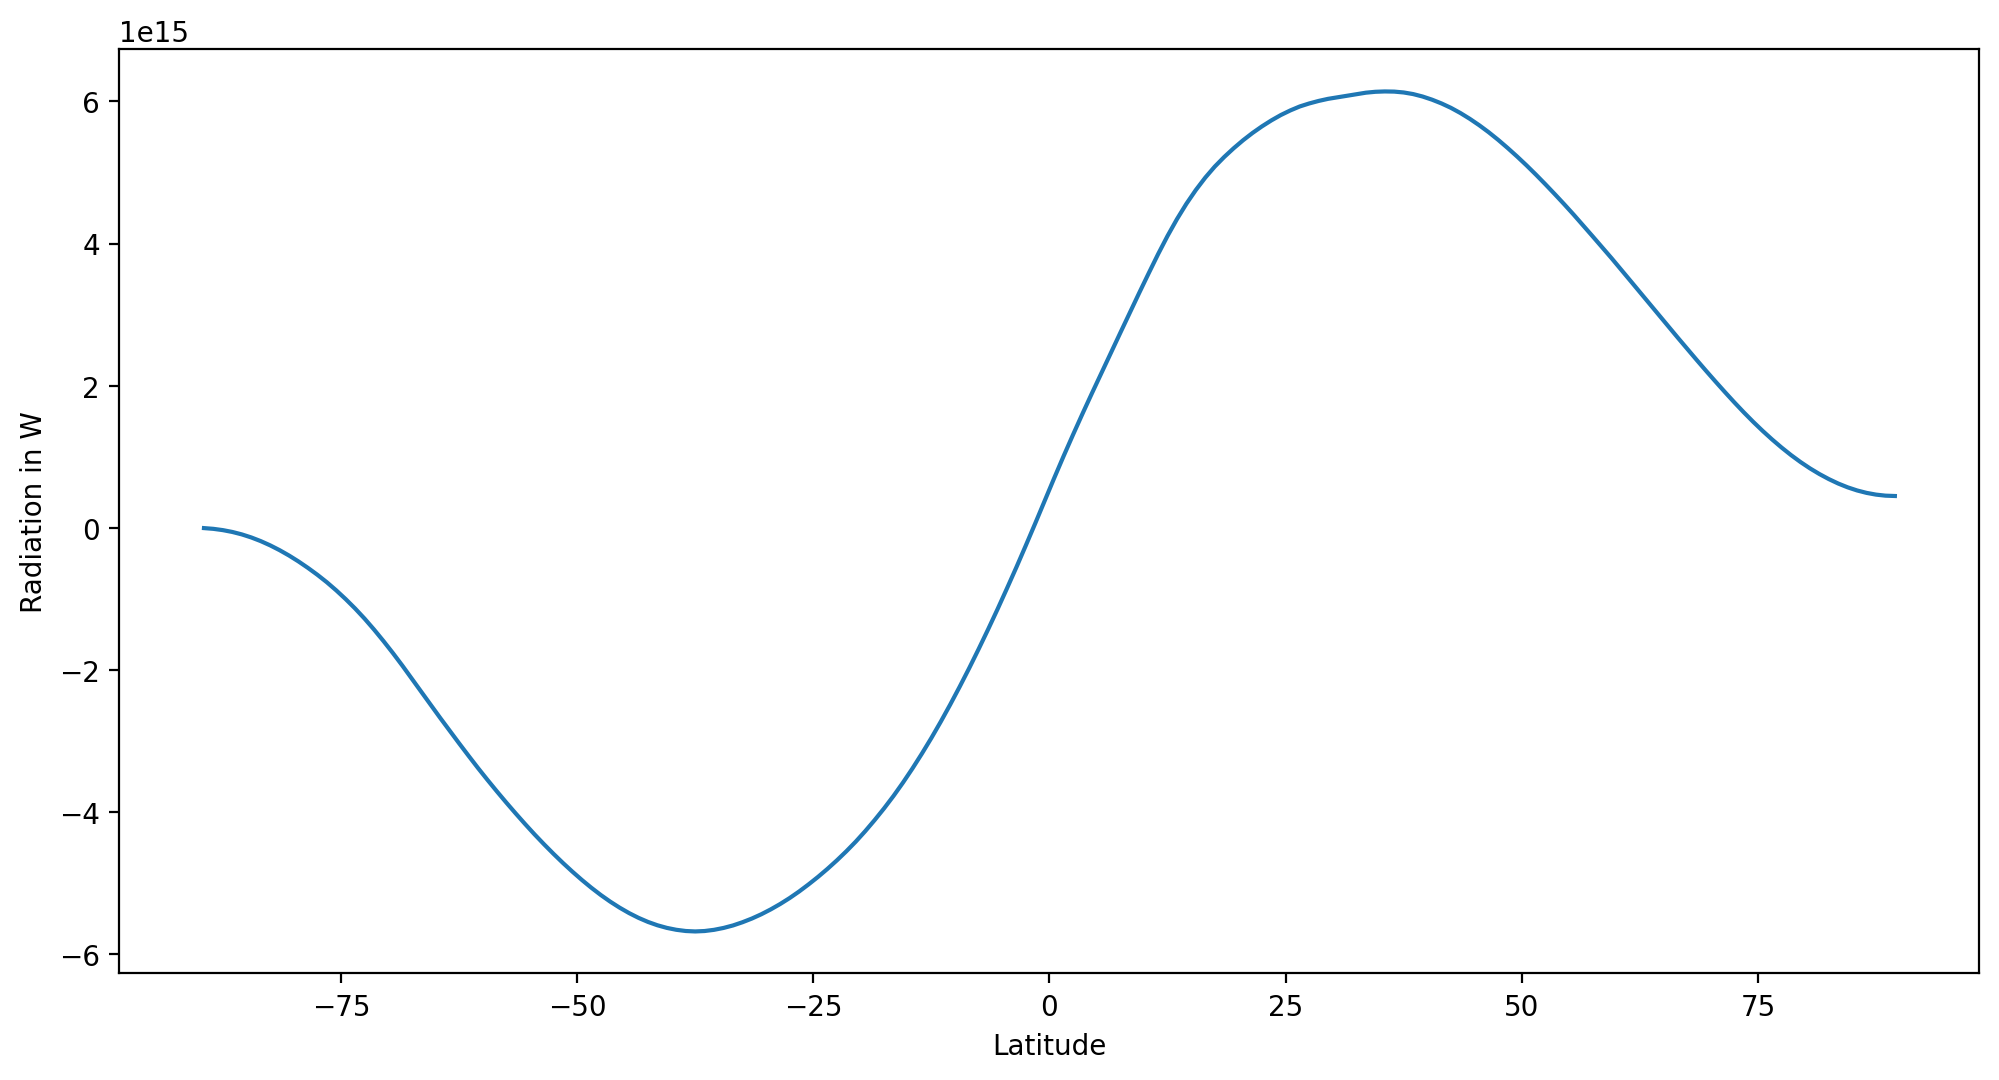

In [258]:
totalrad.sum(dim='lon').cumsum().plot()
plt.xlabel('Latitude') 
plt.ylabel('Radiation in W')

# 5) Selecting and Merging Data

## 5.1) Create a Dataset for each point from the global dataset

In [269]:
dfnew=df.assign(earth_angle=lambda df: (0*df.lon)+np.cos(np.deg2rad(df.lat)))

area=xr.ones_like(dfnew['toa_lw_all_mon'])
dfnew=xr.merge([dfnew,area.rename('area')])
dfnew

dfnew['area']=dfnew.area*(6371000**2)*dfnew.earth_angle*np.deg2rad(1)*np.deg2rad(1)

Text(0.5, 1.0, 'Hobart, Tasmania')

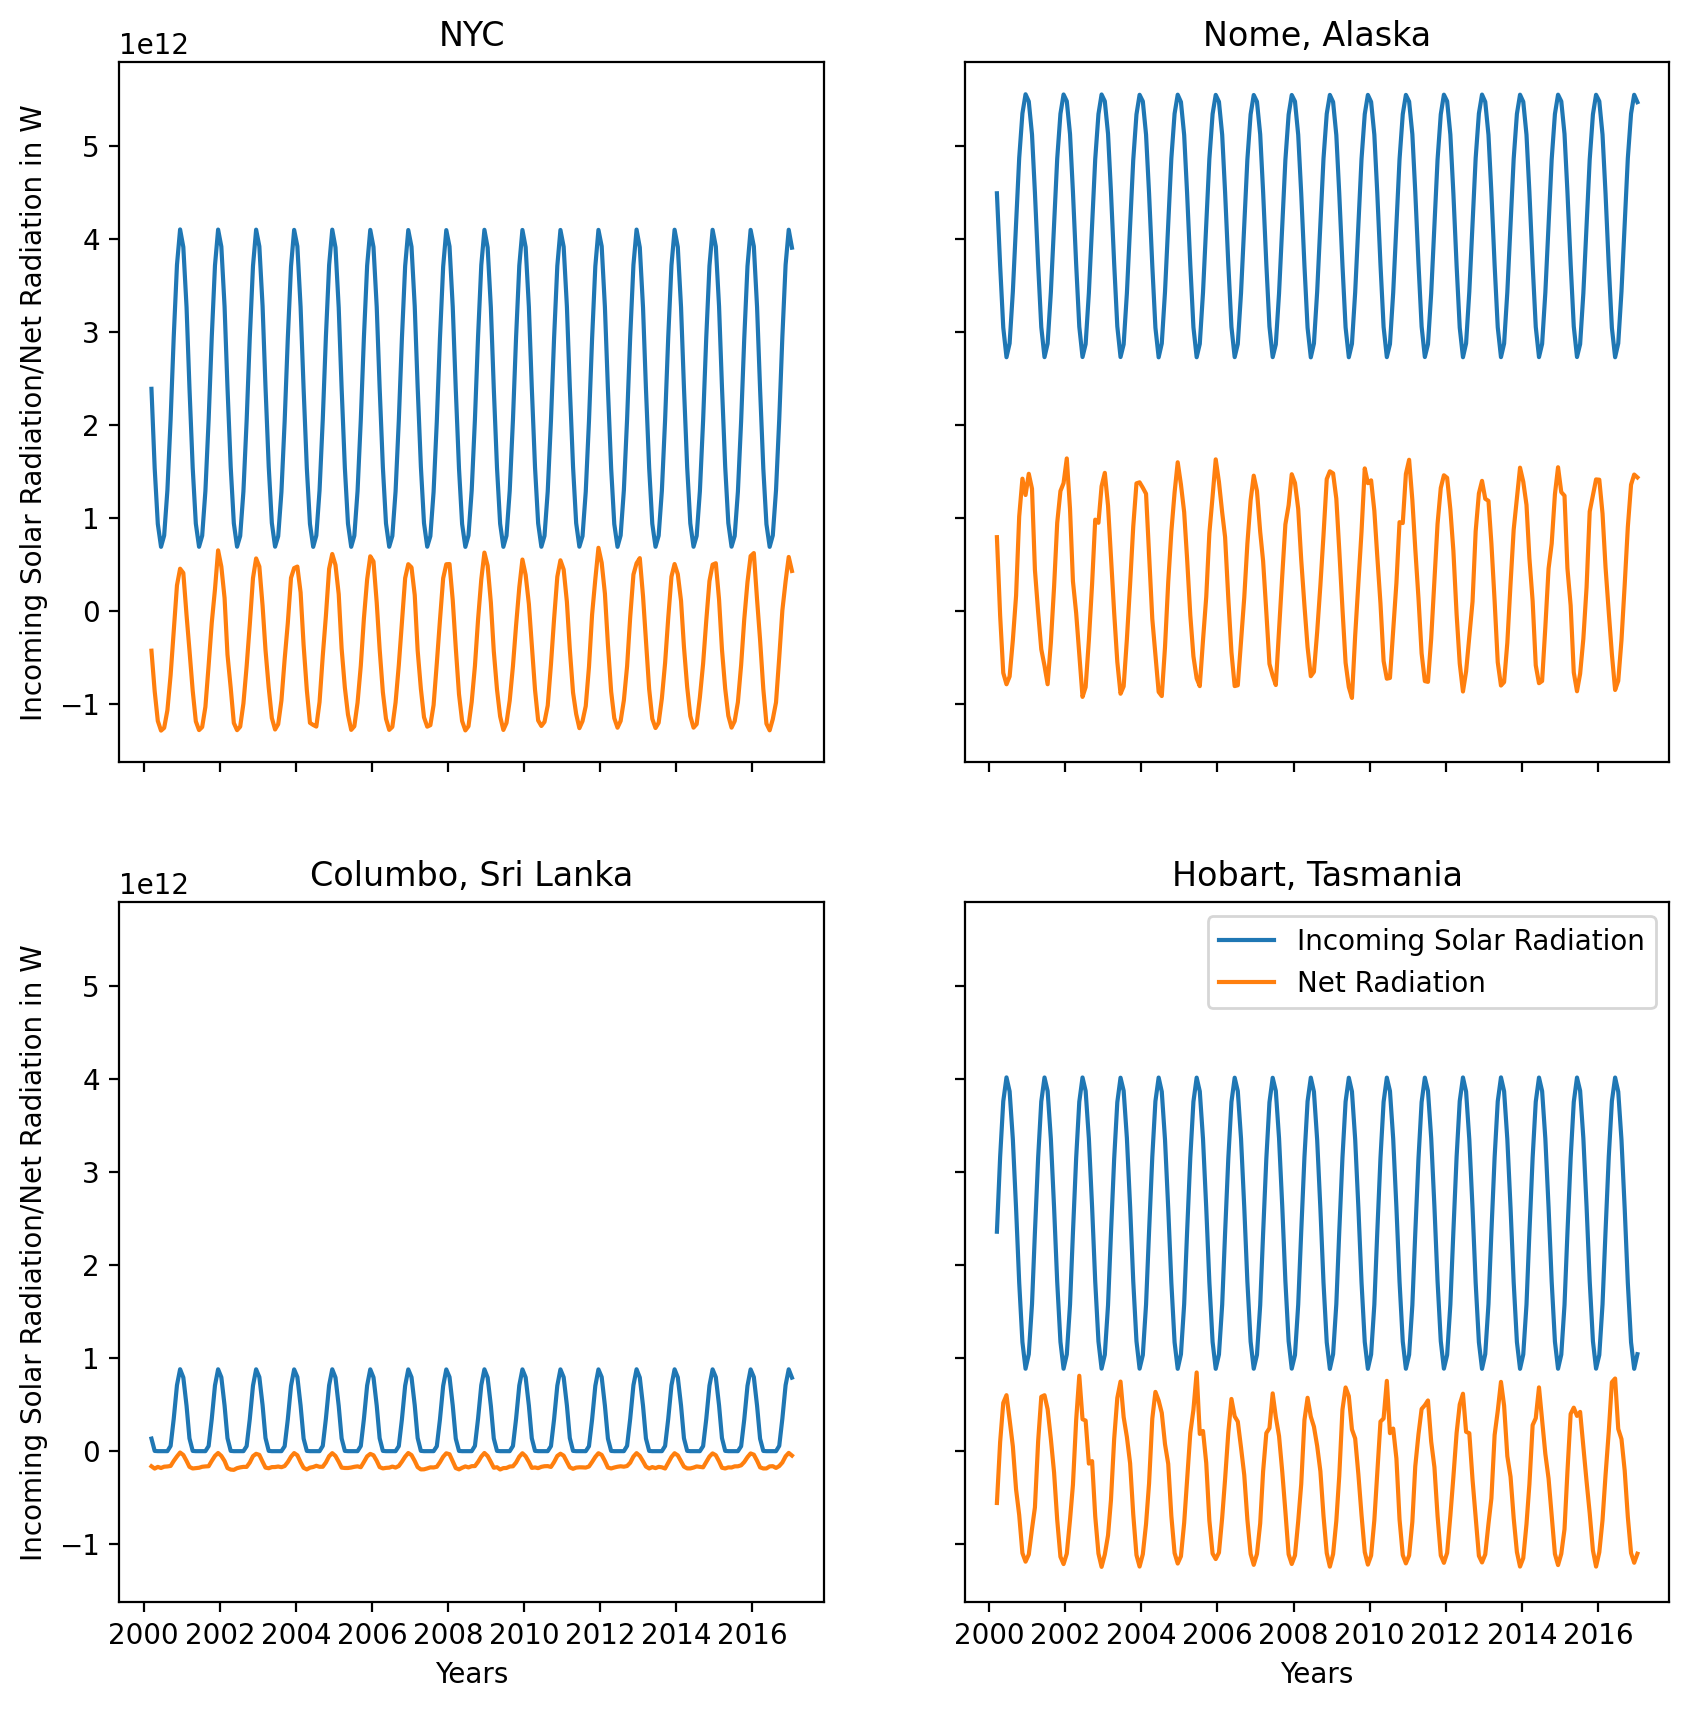

## 
5.2) Merge these four datasets into a new dataset with the new dimension city

In [297]:
merge_df=xr.concat([nyc,nome,columbo,hobart],dim='city')
merge_df['city']=['NYC','Nome','Columbo','Hobart']
merge_df

<xarray.Dataset>
Dimensions:                      (city: 4, time: 203)
Coordinates:
    lon                          (city) float32 286.5 195.5 80.5 147.5
  * time                         (time) datetime64[ns] 2000-03-15 ... 2017-01-15
    lat                          (city) float32 -49.5 -25.5 -82.5 47.5
  * city                         (city) <U7 'NYC' 'Nome' 'Columbo' 'Hobart'
Data variables: (12/16)
    toa_sw_all_mon               (city, time) float32 139.3 87.39 ... 52.07
    toa_lw_all_mon               (city, time) float32 211.0 210.9 ... 204.6
    toa_net_all_mon              (city, time) float32 -52.9 -107.1 ... -131.9
    toa_sw_clr_mon               (city, time) float32 47.07 48.27 ... 32.06
    toa_lw_clr_mon               (city, time) float32 265.1 257.0 ... 229.8
    toa_net_clr_mon              (city, time) float32 -14.77 -114.1 ... -137.1
    ...                           ...
    cldarea_total_daynight_mon   (city, time) float32 75.73 66.66 ... 86.39
    cldpress_total_daynight_mon  (city, time) float32 496.4 499.4 ... 712.2
    cldtemp_total_daynight_mon   (city, time) float32 247.5 246.6 ... 250.2
    cldtau_total_day_mon         (city, time) float32 8.99 8.208 ... 6.606 3.987
    earth_angle                  (city) float32 0.6494 0.9026 0.1305 0.6756
    area                         (city, time) float64 8.03e+09 ... 8.353e+09
Attributes:
    title:             CERES EBAF (Energy Balanced and Filled) TOA Fluxes. Mo...
    institution:       NASA/LaRC (Langley Research Center) Hampton, Va
    Conventions:       CF-1.4
    comment:           Data is from East to West and South to North.
    Version:           Edition 4.0; Release Date March 7, 2017
    Fill_Value:        Fill Value is -999.0
    DOI:               10.5067/TERRA+AQUA/CERES/EBAF-TOA_L3B.004.0
    Production_Files:  List of files used in creating the present Master netC...

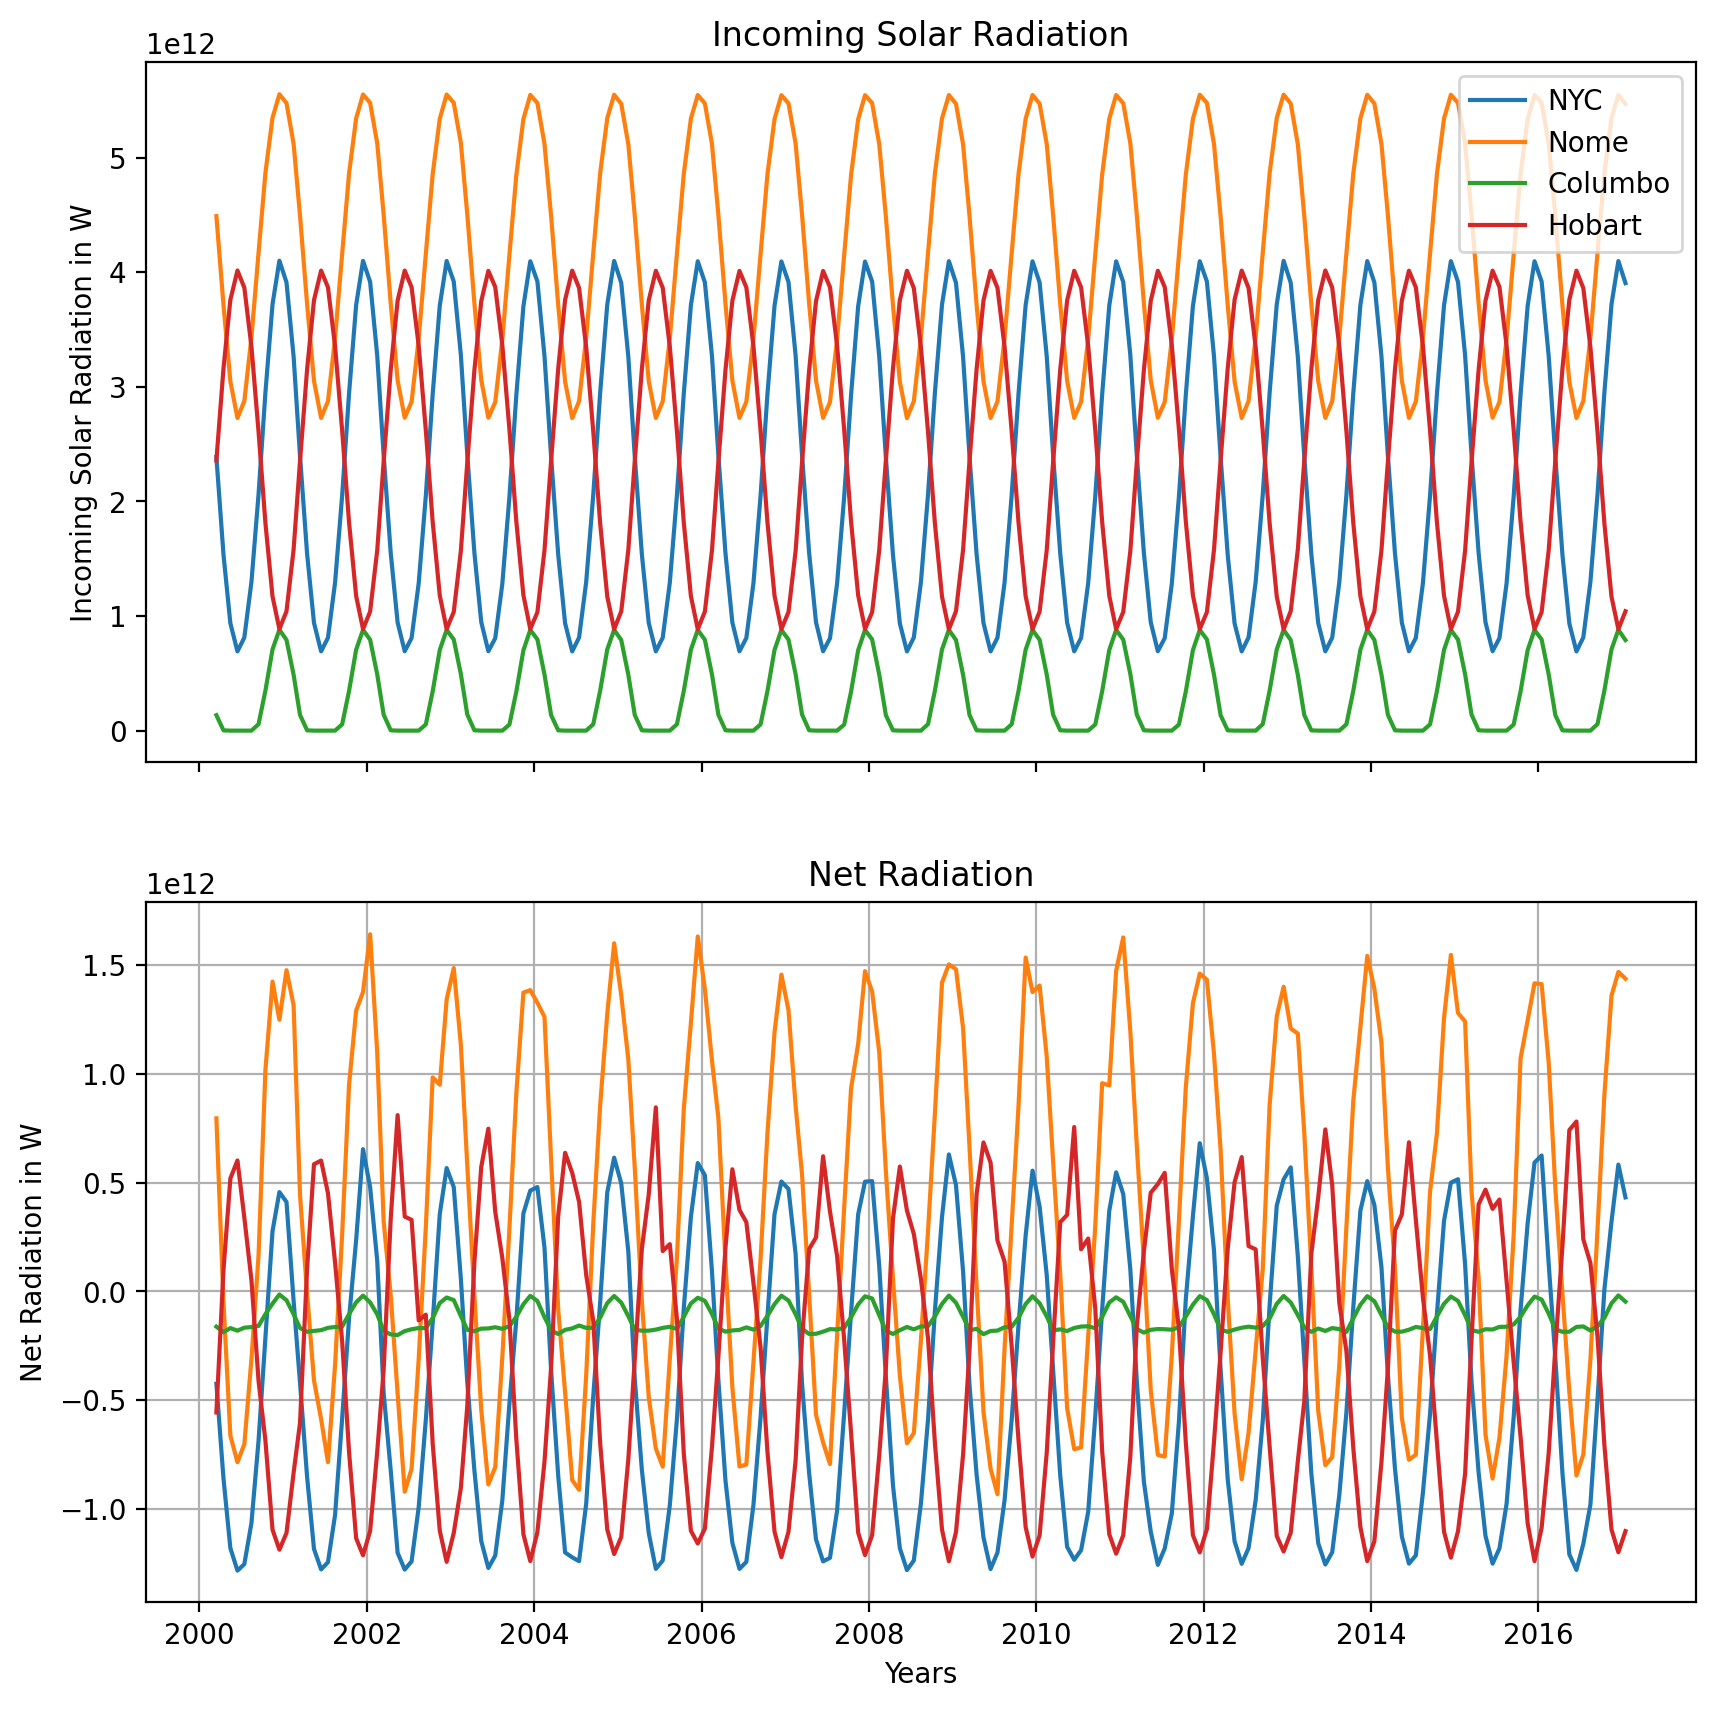

In [311]:
fig,([ax1,ax2])=plt.subplots(2,1,sharex=True,figsize=(10,10))

nyc=dfnew.isel(lat=40,lon=286)
(nyc.solar_mon*nyc.area).plot(ax=ax1,label='NYC')
(nyc.toa_net_all_mon*nyc.area).plot(ax=ax2)

nome=dfnew.isel(lat=64,lon=195)
(nome.solar_mon*nome.area).plot(ax=ax1,label='Nome')
(nome.toa_net_all_mon*nome.area).plot(ax=ax2)

columbo=dfnew.isel(lat=7, lon=80)
(columbo.solar_mon*columbo.area).plot(ax=ax1,label='Columbo')
(columbo.toa_net_all_mon*columbo.area).plot(ax=ax2)

hobart=dfnew.isel(lat=-43,lon=147)
(hobart.solar_mon*hobart.area).plot(ax=ax1,label='Hobart')
(hobart.toa_net_all_mon*hobart.area).plot(ax=ax2)

ax4.legend()
ax1.set_ylabel('Incoming Solar Radiation in W')
ax2.set_ylabel('Net Radiation in W')
ax1.set_title('Incoming Solar Radiation')
ax2.set_title('Net Radiation')
ax1.set_xlabel('')
ax2.set_xlabel('Years')
ax1.legend()
